## Install dependencies

In [ ]:
!pip install catboost
!pip install scikit-learn
!pip install ipywidgets
!jupyter nbextension enable --py widgetsnbextension

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.6 MB 1.2 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.6 MB 5.4 MB/s 
Enabling notebook extension jupyter-js-widgets/extension...
Paths used for configuration of notebook: 
    	/root/.jupyter/nbconfig/notebook.json
Paths used for configuration of notebook: 
    	
      - Validating: OK
Paths used for configuration of notebook: 
    	/root/.jupyter/nbconfig/notebook.json


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score
from catboost import CatBoostClassifier
from catboost import Pool
import matplotlib.pyplot as plt

In [ ]:
from google.colab import output
output.enable_custom_widget_manager()

In [ ]:
from google.colab import output
output.disable_custom_widget_manager()

## Parse data from git repository

In [ ]:
!pip install GitPython

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 182 kB 4.9 MB/s 
     |████████████████████████████████| 62 kB 1.1 MB/s 


In [ ]:
import os
import json
from datetime import datetime

from git import Repo


def is_fix_commit(c):
    return "fix" in c.message.lower()


NAME = "angular"
GIT_URL = "https://github.com/angular/angular"
BRANCH = "main"
COMMITS_LIMIT = 1000

try:
    Repo.clone_from(GIT_URL, f"input/{NAME}")
    print("Cloned")
except:
    print("Already cloned")

if not os.path.exists("output"):
    os.makedirs("output")

analyse_repo = Repo(f"input/{NAME}")
analyse_data = []
commits_count = len(list(analyse_repo.iter_commits(BRANCH))[:COMMITS_LIMIT])
changed_files = set()
start_time = datetime.now()

print(f"Start analyse {NAME}\nTotal commits:", commits_count)
for index, commit in enumerate(list(analyse_repo.iter_commits(BRANCH))[:COMMITS_LIMIT][::-1]):
    if commit.message.startswith("Merge"):
        continue

    if index % 100 == 0:
        print(f"Analyse {index} of {commits_count}\n"
              f"Elapsed time: {datetime.now() - start_time}\n"
              f"For one commit: {(datetime.now() - start_time) / (index + 1)}\n"
              f"Estimated time: {(datetime.now() - start_time) / (index + 1) * (commits_count - index)}\n")
        json.dump(analyse_data, open(f"output/analyse_data_{NAME}.json", "w"), indent=4)
    if index % 2000 == 0:
      json.dump(analyse_data, open(f"output/analyse_data_{NAME}__snap.json", "w"), indent=4)

    for file in commit.stats.files:
        if is_fix_commit(commit):
            for a in analyse_data[::-1]:
                if a["file"] == file:
                    a["is_broken"] = True
                    break

        analyse_data.append({
            "file": file,
            "author": commit.author.name,
            "msg": commit.message,
            "date": int(commit.committed_datetime.timestamp()),
            "is_broken": False,
        })

json.dump(analyse_data, open(f"output/analyse_data_{NAME}.json", "w"), indent=4)

print(
    f"Ready! Elapsed time: {datetime.now() - start_time}\n"
    f"For one commit: {(datetime.now() - start_time) / commits_count}\n"
)


Already cloned
Start analyse angular
Total commits: 1000
Analyse 0 of 1000
Elapsed time: 0:00:00.679946
For one commit: 0:00:00.679977
Estimated time: 0:11:19.984000

Analyse 100 of 1000
Elapsed time: 0:00:02.931577
For one commit: 0:00:00.029026
Estimated time: 0:00:26.123400

Analyse 200 of 1000
Elapsed time: 0:00:05.390021
For one commit: 0:00:00.026816
Estimated time: 0:00:21.452800

Analyse 300 of 1000
Elapsed time: 0:00:07.878123
For one commit: 0:00:00.026173
Estimated time: 0:00:18.321100

Analyse 400 of 1000
Elapsed time: 0:00:10.199760
For one commit: 0:00:00.025436
Estimated time: 0:00:15.261600

Analyse 500 of 1000
Elapsed time: 0:00:12.508429
For one commit: 0:00:00.024967
Estimated time: 0:00:12.483500

Analyse 600 of 1000
Elapsed time: 0:00:14.876408
For one commit: 0:00:00.024753
Estimated time: 0:00:09.901200

Analyse 700 of 1000
Elapsed time: 0:00:17.194748
For one commit: 0:00:00.024529
Estimated time: 0:00:07.358700

Analyse 800 of 1000
Elapsed time: 0:00:19.529308


## Train model

In [ ]:
data_src = "output/analyse_data_angular.json"

df = pd.read_json(data_src)

df['date'] = df['date'].astype(str) 

df.head(10)

,file,author,msg,date,is_broken
0,.gitignore,Miško Hevery,Initial commit\n,2014-09-18 16:12:01,False
1,LICENSE,Miško Hevery,Initial commit\n,2014-09-18 16:12:01,False
2,.gitignore,Tobias Bosch,build - refactor,2014-09-19 20:59:28,False
3,.gitmodules,Tobias Bosch,build - refactor,2014-09-19 20:59:28,False
4,TODO.md,Tobias Bosch,build - refactor,2014-09-19 20:59:28,False
5,gulpfile.js,Tobias Bosch,build - refactor,2014-09-19 20:59:28,False
6,modules/examples/src/todo/app.es6d,Tobias Bosch,build - refactor,2014-09-19 20:59:28,False
7,modules/examples/src/todo/dom.dart,Tobias Bosch,build - refactor,2014-09-19 20:59:28,False
8,modules/examples/src/todo/dom.es6,Tobias Bosch,build - refactor,2014-09-19 20:59:28,False
9,modules/examples/src/todo/index.html,Tobias Bosch,build - refactor,2014-09-19 20:59:28,False


In [ ]:
train_df, test_df = train_test_split(df, test_size=0.2)

train_data, train_labels = train_df.loc[:, train_df.columns != 'is_broken'], train_df['is_broken'].astype(int)
test_data, test_labels = test_df.loc[:, train_df.columns != 'is_broken'], test_df['is_broken'].astype(int)

cat_features = [0, 1, 2, 3]
additional_metrics = ['Recall', 'Precision', 'Accuracy', 'F1']

In [ ]:
model = CatBoostClassifier(
    cat_features=cat_features,
    random_seed=2,
    custom_metric=additional_metrics,
    train_dir = "bccommits"
)

In [11]:
model.fit(train_data, train_labels)

Learning rate set to 0.087766
0:	learn: 0.6558089	total: 589ms	remaining: 9m 48s
1:	learn: 0.6251874	total: 995ms	remaining: 8m 16s
2:	learn: 0.5845249	total: 1.32s	remaining: 7m 18s
3:	learn: 0.5515825	total: 1.53s	remaining: 6m 21s
4:	learn: 0.5264271	total: 1.65s	remaining: 5m 28s
5:	learn: 0.5072840	total: 1.76s	remaining: 4m 51s
6:	learn: 0.4921087	total: 1.87s	remaining: 4m 25s
7:	learn: 0.4800419	total: 1.98s	remaining: 4m 5s
8:	learn: 0.4675824	total: 2.11s	remaining: 3m 52s
9:	learn: 0.4619302	total: 2.19s	remaining: 3m 36s
10:	learn: 0.4554806	total: 2.29s	remaining: 3m 26s
11:	learn: 0.4487426	total: 2.44s	remaining: 3m 20s
12:	learn: 0.4433456	total: 2.56s	remaining: 3m 14s
13:	learn: 0.4372139	total: 2.69s	remaining: 3m 9s
14:	learn: 0.4322667	total: 2.83s	remaining: 3m 5s
15:	learn: 0.4273571	total: 2.94s	remaining: 3m
16:	learn: 0.4240287	total: 3.08s	remaining: 2m 58s
17:	learn: 0.4215468	total: 3.2s	remaining: 2m 54s
18:	learn: 0.4190642	total: 3.32s	remaining: 2m 51s


In [12]:
model.get_feature_importance()
# Output shows importance: file, author, msg, date

array([20.39152392, 27.74386096, 31.34459581, 20.52001932])

In [13]:
predict = model.predict(test_data)

## Learn metrics

In [14]:
print(f"Precision: {precision_score(test_labels.astype(int), pd.DataFrame(predict)[0].astype(int))}")

Precision: 0.6988664366683095


In [15]:
import json

import pandas as pd

learn_info = dict.fromkeys(['Logloss'] + additional_metrics , [])
df = pd.DataFrame.from_dict(learn_info)

with open("bccommits/catboost_training.json", "r") as f:
    data = json.load(f)

for index, i in enumerate(data["iterations"]):
  df.loc[index] = i['learn']

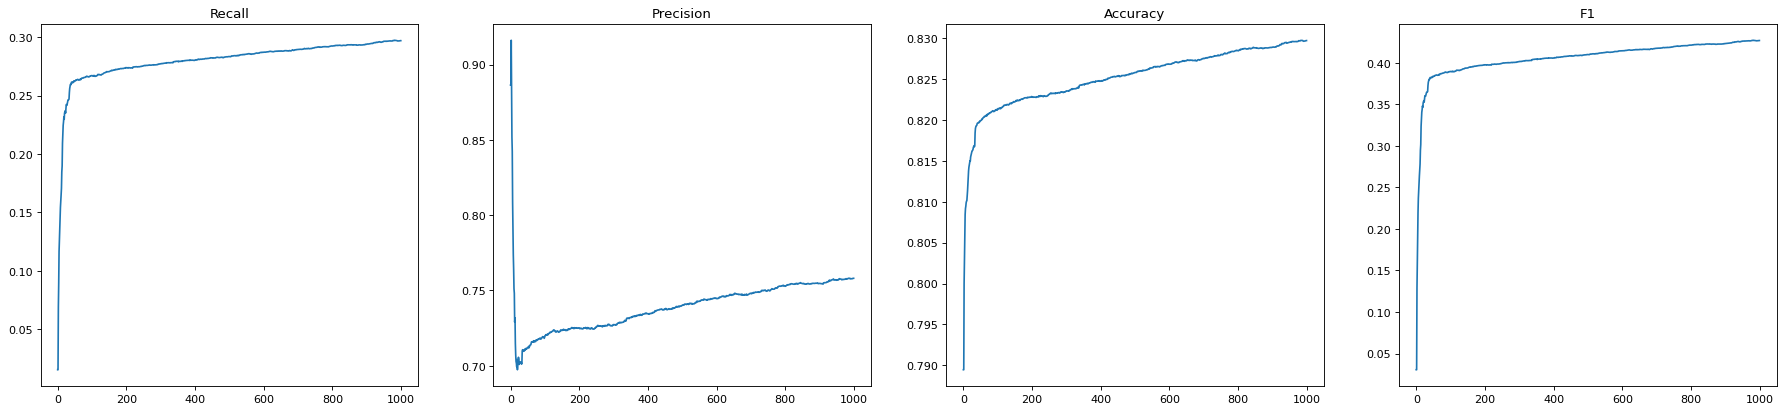

In [16]:
from matplotlib.pyplot import figure

fig, axs = plt.subplots(1, 4, figsize=(28, 6), dpi=200)

df['Recall'].plot(ax=axs[0], title="Recall")
df['Precision'].plot(ax=axs[1], title="Precision")
df['Accuracy'].plot(ax=axs[2], title="Accuracy")
df['F1'].plot(ax=axs[3], title="F1")


## Predict for custom data

In [21]:
test_data.head(10)

,file,author,msg,date
125595,packages/core/src/render3/instructions/advance.ts,Miško Hevery,refactor(ivy): Switch styling to new reconcile...,2020-01-24 20:23:00
37986,modules/@angular/{common/src/forms => forms/sr...,Kara,feat(forms): add easy way to switch between fo...,2016-06-15 01:23:40
183892,aio/src/styles/0-base/_typography.scss,dario-piotrowicz,refactor(docs-infra): create external-link-wit...,2022-06-24 22:28:01
84725,aio/package.json,Igor Minar,build(aio): update to @angular/core@6.0.0-beta...,2018-03-23 16:53:58
68842,tools/@angular/tsc-wrapped/package.json,Matias Niemelä,release: cut the 4.3.0-beta.1 release\n,2017-06-29 21:38:52
21908,modules/angular2/src/core/change_detection/cha...,Alex Eagle,chore(typings): mark underscore methods @inter...,2015-10-10 02:18:33
68156,aio/content/images/marketing/angular-mix.png,Igor Minar,feat(aio): update the home page and docs landi...,2017-06-08 22:26:15
30122,modules/playground/src/web_workers/message_bro...,Alex Eagle,chore(format): update to latest formatter\n\nC...,2016-04-11 22:15:23
4454,modules/angular2/src/core/compiler/shadow_dom_...,Marc Laval,refactor(compiler): remove direct accesses to ...,2015-03-11 10:58:18
43928,modules/@angular/platform-browser/test/web_wor...,Alex Eagle,chore(imports): don't import ExceptionHandler ...,2016-08-10 22:55:18


In [30]:
test_indexes = [125595, 37986, 183892, 84725, 68842, 21908, 43928, 4454, 30122]

for i in test_indexes:
  print(model.predict_proba(test_data.loc[i])[0])

0.8472395649558441
0.9444556847532986
0.667945135159776
0.9788462205733685
0.8292216802275809
0.759843331045466
0.49204345566978636
0.8828657513422236
0.9761091478141541
